# CS7643 - Final Project

In [1]:
# built-in
from collections import Counter
# public
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
# private
from config import Config, InstrConfig, ILConfig
from src.utils import dataloader, helpers
from src.models.instructions_generator_model import InstructionsGeneratorModel
from src.trainer import instructions_generator_trainer
from src.models.imitation_learning_model import ImitationLearningModel
from src.trainer import imitation_learning_trainer
from src.models.imitation_learning_generative_language_model import ImitationLearningGenerativeLanguageModel
from src.trainer import imitation_learning_generative_language_trainer
from src.gamer import game_env

%load_ext autoreload 
%autoreload 2
%config Completer.use_jedi = False

# Initialization

In [2]:
config = Config()
helpers.set_seed(config.random_seed)

# Data

## Load Data

In [3]:
# train size 202831
# unique number of instructions 35921
data = dataloader.load_pkl(workdir=config.DATA_PATH)

In [4]:
train_states, train_inventories, train_actions, train_goals, train_instructions, all_instructions = data

In [5]:
# remove invalid sample where train instruction is None
invalid_index = set([i for i, _ in enumerate(train_instructions) if not _])
print(len(invalid_index))

34


In [6]:
valid_index = [i for i, _ in enumerate(train_instructions) if _]
print(len(valid_index))
train_states = np.array(train_states)[valid_index].tolist()
train_inventories = np.array(train_inventories)[valid_index].tolist()
train_actions = np.array(train_actions)[valid_index].tolist()
train_instructions = np.array(train_instructions)[valid_index].tolist()

202797


In [7]:
# action size
c = Counter()
c.update(train_actions)
print(c)
len(c)

Counter({'up': 37842, 'left': 37539, 'down': 37211, 'right': 35955, 'grab': 14583, 'craft': 13064, 'mine': 11701, 'toggle_switch': 7504, 'stop': 7398})


9

## Build Vocab

In [8]:
vocab, vocab_weights = dataloader.generate_vocab(
    all_instructions
    , config.device
    , workdir=config.DATA_PATH
    , cache=config.glove_cache)

Total vocabulary size: 212


---

# Instructions Generator

## Generate Dataset

In [9]:
instr_config = InstrConfig()
print(instr_config.validation_split)
print(instr_config.random_seed)

0.2
321


In [10]:
dataset = dataloader.CraftingDataset(
    instr_config.embedding_dim
    , train_states
    , train_inventories
    , train_actions
    , train_goals
    , train_instructions
    , vocab
    , cache=instr_config.glove_cache)

embedding loaded
one hot loaded
actions loaded
goals loaded
done loading dataset


In [11]:
min([len(d[-1]) for d in dataset])

3

In [12]:
instr_config.dataset_size = len(dataset)

## Split Dataset

In [13]:
indices = list(range(instr_config.dataset_size))
split = int(np.floor(instr_config.validation_split * instr_config.dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Initialize Data Loader

In [14]:
train_data_loader = DataLoader(
  dataset,
  batch_size=instr_config.batch_size,
  num_workers=instr_config.num_workers,
  pin_memory=True,
  sampler=train_sampler,
  collate_fn=dataloader.collate_fn)

validation_data_loader = DataLoader(
  dataset,
  batch_size=instr_config.batch_size,
  num_workers=instr_config.num_workers,
  pin_memory=True,
  sampler=valid_sampler,
  collate_fn=dataloader.collate_fn)

## Setup Training

In [15]:
model = InstructionsGeneratorModel(
    instr_config.device
    , vocab
    , instr_config.embedding_dim
    , vocab_weights
).to(instr_config.device)
train = instructions_generator_trainer.train
validate = instructions_generator_trainer.validate
# CE Loss
criterion = torch.nn.CrossEntropyLoss()
# Adam
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=instr_config.learning_rate)
# Log
writer = SummaryWriter() if instr_config.summary_writer else None

In [23]:
instr_config.teacher_forcing_rate = 1

## GO

In [24]:
best_valid_loss, best_valid_bleu, best_valid_tk_acc = float('inf'), float('inf'), float('inf')
valid_epoch, best_epoch = 0, None

train_losses = []
train_accuracy = []
valid_losses = []
valid_accuracy = []

for epoch in range(instr_config.epochs):
    # train
    loss, bleu, tk_acc = train(
        instr_config.device,
        epoch,
        train_data_loader,
        model,
        optimizer,
        criterion,
        parameters,
        vocab,
        instr_config,
        summary_writer=writer)
    print('Overall Epoch: %d, train loss: %.3f, train bleu: %.3f, train token acc: %.3f' % (epoch, loss, bleu, tk_acc))
    train_losses.append(loss)
    train_accuracy.append(tk_acc)
    # valid
    loss, bleu, tk_acc = validate(
        instr_config.device,
        epoch,
        validation_data_loader,
        model,
        criterion,
        vocab,
        summary_writer=writer)
    valid_losses.append(loss)
    valid_accuracy.append(tk_acc)
    print('Overall Epoch: %d, valid loss: %.3f, valid bleu: %.3f, valid token acc: %.3f' % (epoch, loss, bleu, tk_acc))
    # early stopping
    if loss <= best_valid_loss:
        best_valid_loss, best_valid_bleu, best_valid_tk_acc = loss, bleu, tk_acc
        valid_epoch, best_epoch = 0, epoch
        torch.save(model.state_dict(), instr_config.SAVE_PATH)
        print('Best Epoch: %d, valid loss: %.3f, valid bleu: %.3f, valid token acc: %.3f' \
              % (best_epoch, best_valid_loss, best_valid_bleu, best_valid_tk_acc))
        print('Trained model saved at ', instr_config.SAVE_PATH)
    else:
        valid_epoch += 1
        if valid_epoch >= instr_config.valid_patience:
            break

Epoch: 0, train loss: 1.979, train bleu: 0.596, train token acc: 0.768: 100%|██████████| 2535/2535 [04:03<00:00, 10.40it/s]


Overall Epoch: 0, train loss: 2.260, train bleu: 0.600, train token acc: 0.749


Epoch: 0, valid loss: 5.718, valid bleu: 0.229, valid token acc: 0.210: 100%|██████████| 634/634 [01:03<00:00,  9.97it/s]


Overall Epoch: 0, valid loss: 5.865, valid bleu: 0.282, valid token acc: 0.270
Best Epoch: 0, valid loss: 5.865, valid bleu: 0.282, valid token acc: 0.270
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/instr_gen.pt


Epoch: 1, train loss: 2.051, train bleu: 0.585, train token acc: 0.743: 100%|██████████| 2535/2535 [04:02<00:00, 10.47it/s]


Overall Epoch: 1, train loss: 2.091, train bleu: 0.624, train token acc: 0.769


Epoch: 1, valid loss: 6.231, valid bleu: 0.301, valid token acc: 0.259: 100%|██████████| 634/634 [01:11<00:00,  8.92it/s]


Overall Epoch: 1, valid loss: 6.102, valid bleu: 0.283, valid token acc: 0.257


Epoch: 2, train loss: 2.066, train bleu: 0.677, train token acc: 0.795: 100%|██████████| 2535/2535 [04:13<00:00, 10.00it/s]


Overall Epoch: 2, train loss: 2.043, train bleu: 0.632, train token acc: 0.775


Epoch: 2, valid loss: 6.161, valid bleu: 0.314, valid token acc: 0.289: 100%|██████████| 634/634 [01:11<00:00,  8.92it/s]


Overall Epoch: 2, valid loss: 6.452, valid bleu: 0.283, valid token acc: 0.248


Epoch: 3, train loss: 2.106, train bleu: 0.684, train token acc: 0.800: 100%|██████████| 2535/2535 [04:12<00:00, 10.03it/s]


Overall Epoch: 3, train loss: 2.016, train bleu: 0.635, train token acc: 0.778


Epoch: 3, valid loss: 6.474, valid bleu: 0.349, valid token acc: 0.286: 100%|██████████| 634/634 [01:14<00:00,  8.51it/s]


Overall Epoch: 3, valid loss: 6.564, valid bleu: 0.287, valid token acc: 0.238


Epoch: 4, train loss: 2.006, train bleu: 0.595, train token acc: 0.770: 100%|██████████| 2535/2535 [04:12<00:00, 10.02it/s]


Overall Epoch: 4, train loss: 1.995, train bleu: 0.639, train token acc: 0.780


Epoch: 4, valid loss: 6.768, valid bleu: 0.231, valid token acc: 0.249: 100%|██████████| 634/634 [01:13<00:00,  8.68it/s]

Overall Epoch: 4, valid loss: 6.701, valid bleu: 0.284, valid token acc: 0.244


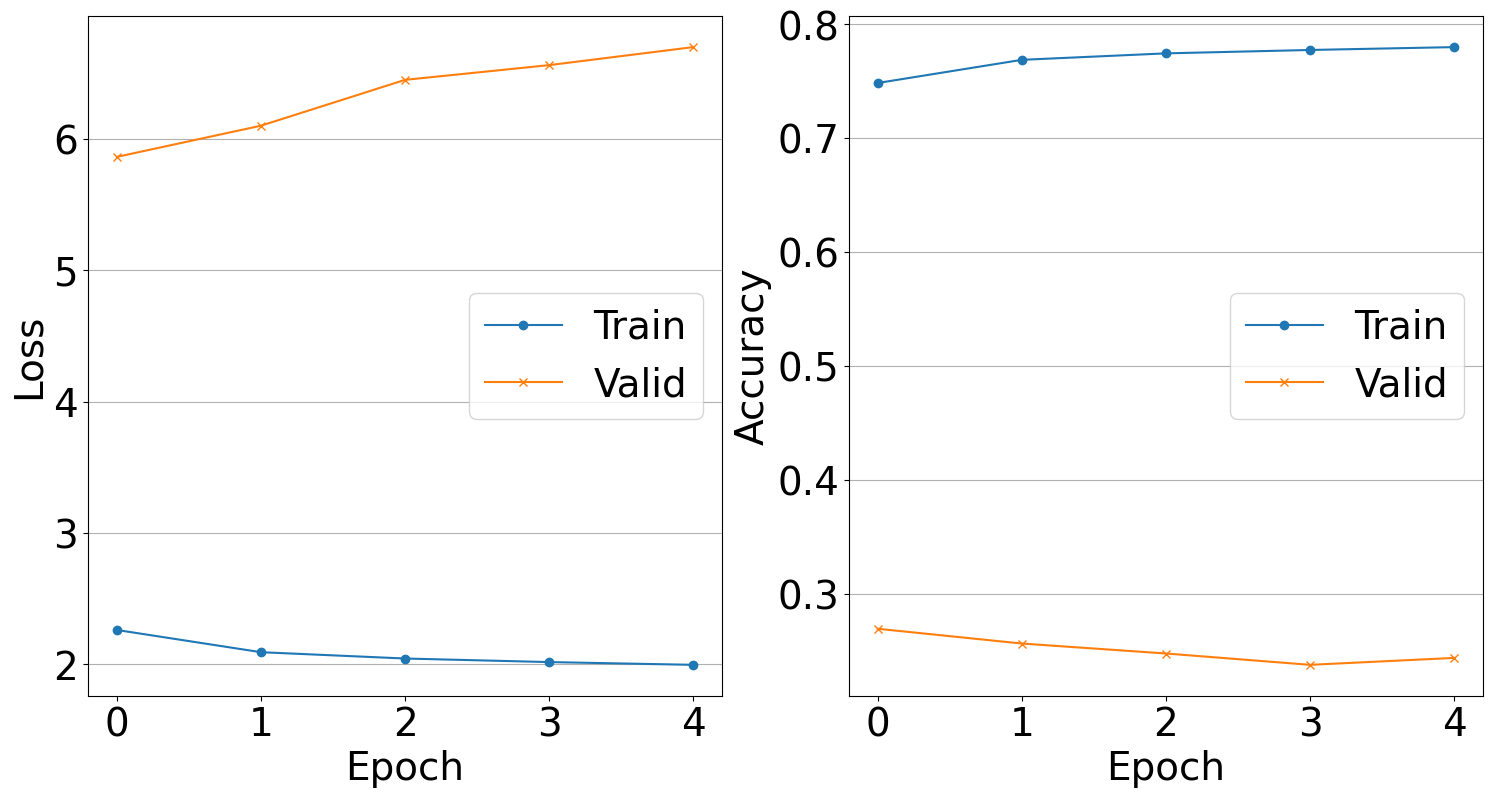

In [25]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), dpi=100)
plot1 = axes[0].plot(range(len(train_losses)), train_losses, marker='o', label='Train')
plot1 = axes[0].plot(range(len(train_losses)), valid_losses, marker='x', label='Valid')

plot2 = axes[1].plot(range(len(train_accuracy)), train_accuracy, marker='o', label='Train')
plot2 = axes[1].plot(range(len(train_accuracy)), valid_accuracy, marker='x', label='Valid')

ylabels = ['Loss', 'Accuracy']
for i in range(2):
    axes[i].legend()
    axes[i].set_xticks([y for y in range(len(train_losses))])
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel('Epoch')
    axes[i].yaxis.grid(True)
    
fig.savefig('instructions_generator_1_0_teacher_forcing.png')

---

# Reinforcement Learning (RL) - Pre-training

## Common Imitation Learning (IL) Setup

### Initialization

In [31]:
il_config = ILConfig()
il_config.random_seed = 321
il_config.validation_split = 0.2
il_config.epochs = 20

### Generate Dataset

In [32]:
dataset = dataloader.CraftingDataset(
  il_config.embedding_dim,
  train_states,
  train_inventories,
  train_actions,
  train_goals,
  train_instructions,
  vocab,
  cache=config.glove_cache)

embedding loaded
one hot loaded
actions loaded
goals loaded
done loading dataset


In [33]:
il_config.dataset_size = len(dataset)

### Split Dataset

In [34]:
indices = list(range(il_config.dataset_size))
split = int(np.floor(il_config.validation_split * il_config.dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

### Initialize Data Loader

In [35]:
train_data_loader = DataLoader(
  dataset,
  batch_size=il_config.batch_size,
  num_workers=il_config.num_workers,
  pin_memory=True,
  sampler=train_sampler,
  collate_fn=dataloader.collate_fn)

validation_data_loader = DataLoader(
  dataset,
  batch_size=il_config.batch_size,
  num_workers=il_config.num_workers,
  pin_memory=True,
  sampler=valid_sampler,
  collate_fn=dataloader.collate_fn)

## Vanilla Imitation Learning

### Setup

In [17]:
model = ImitationLearningModel(il_config).to(il_config.device)
train = imitation_learning_trainer.train
validate = imitation_learning_trainer.validate
validate_game = imitation_learning_trainer.validate_game
# CE Loss
criterion = torch.nn.CrossEntropyLoss()
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=il_config.learning_rate)
# Log
writer = SummaryWriter() if il_config.summary_writer else None

### GO

In [18]:
best_valid_loss, best_valid_acc, best_valid_reward= float('inf'), float('inf'), float('inf')
valid_epoch, best_epoch = 0, None

for epoch in range(il_config.epochs):
    # train
    loss, accuracy = train(epoch, train_data_loader, model, optimizer, criterion, il_config, summary_writer=writer)
    print('Overall Epoch: %d, train loss: %.3f, train accuracy: %.3f' % (epoch, loss, accuracy))
    # valid
    loss, accuracy = validate(epoch, validation_data_loader, model, criterion, il_config, summary_writer=writer)
    # valid game
    sum_rewards = validate_game(epoch, model, il_config, cache=config.glove_cache)
    print('Overall Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid sum rewards: %.3f' % (epoch, loss, accuracy, sum_rewards))
    # early stopping
    if loss <= best_valid_loss:
        best_valid_loss, best_valid_acc, best_valid_reward = loss, accuracy, sum_rewards
        valid_epoch, best_epoch = 0, epoch
        torch.save(model.state_dict(), il_config.SAVE_PATH)
        print('Best Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid sum rewards: %.3f' \
              % (best_epoch, best_valid_loss, best_valid_acc, best_valid_reward))
        print('Trained model saved at ', il_config.SAVE_PATH)
    else:
        valid_epoch += 1
        if valid_epoch >= il_config.valid_patience:
            break

Epoch: 0, train loss: 0.895, train accuracy: 0.710: 100%|██████████| 2535/2535 [00:41<00:00, 61.51it/s]


Overall Epoch: 0, train loss: 1.268, train accuracy: 0.512


Epoch: 0, valid loss: 0.909, valid accuracy: 0.617: 100%|██████████| 634/634 [00:06<00:00, 91.87it/s] 
100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Overall Epoch: 0, valid loss: 1.029, valid accuracy: 0.621, valid sum rewards: 1.000
Best Epoch: 0, valid loss: 1.029, valid accuracy: 0.621, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 1, train loss: 1.005, train accuracy: 0.677: 100%|██████████| 2535/2535 [00:39<00:00, 64.96it/s]


Overall Epoch: 1, train loss: 0.983, train accuracy: 0.635


Epoch: 1, valid loss: 0.936, valid accuracy: 0.660: 100%|██████████| 634/634 [00:06<00:00, 97.71it/s] 
100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Overall Epoch: 1, valid loss: 0.959, valid accuracy: 0.642, valid sum rewards: 1.000
Best Epoch: 1, valid loss: 0.959, valid accuracy: 0.642, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 2, train loss: 0.819, train accuracy: 0.694: 100%|██████████| 2535/2535 [00:39<00:00, 63.82it/s]


Overall Epoch: 2, train loss: 0.904, train accuracy: 0.664


Epoch: 2, valid loss: 0.685, valid accuracy: 0.766: 100%|██████████| 634/634 [00:06<00:00, 95.33it/s] 
100%|██████████| 15/15 [00:04<00:00,  3.58it/s]


Overall Epoch: 2, valid loss: 0.898, valid accuracy: 0.668, valid sum rewards: 1.000
Best Epoch: 2, valid loss: 0.898, valid accuracy: 0.668, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 3, train loss: 0.943, train accuracy: 0.629: 100%|██████████| 2535/2535 [00:41<00:00, 61.28it/s]


Overall Epoch: 3, train loss: 0.840, train accuracy: 0.692


Epoch: 3, valid loss: 1.144, valid accuracy: 0.574: 100%|██████████| 634/634 [00:07<00:00, 89.63it/s] 
100%|██████████| 15/15 [00:04<00:00,  3.62it/s]


Overall Epoch: 3, valid loss: 0.877, valid accuracy: 0.677, valid sum rewards: 1.000
Best Epoch: 3, valid loss: 0.877, valid accuracy: 0.677, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 4, train loss: 0.752, train accuracy: 0.726: 100%|██████████| 2535/2535 [00:43<00:00, 58.89it/s]


Overall Epoch: 4, train loss: 0.778, train accuracy: 0.719


Epoch: 4, valid loss: 0.786, valid accuracy: 0.681: 100%|██████████| 634/634 [00:07<00:00, 88.98it/s] 
100%|██████████| 15/15 [00:04<00:00,  3.73it/s]


Overall Epoch: 4, valid loss: 0.845, valid accuracy: 0.695, valid sum rewards: 1.000
Best Epoch: 4, valid loss: 0.845, valid accuracy: 0.695, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 5, train loss: 0.896, train accuracy: 0.613: 100%|██████████| 2535/2535 [00:42<00:00, 60.21it/s]


Overall Epoch: 5, train loss: 0.723, train accuracy: 0.738


Epoch: 5, valid loss: 0.819, valid accuracy: 0.723: 100%|██████████| 634/634 [00:06<00:00, 92.70it/s] 
100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Overall Epoch: 5, valid loss: 0.830, valid accuracy: 0.703, valid sum rewards: 1.000
Best Epoch: 5, valid loss: 0.830, valid accuracy: 0.703, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 6, train loss: 0.595, train accuracy: 0.823: 100%|██████████| 2535/2535 [00:41<00:00, 60.99it/s]


Overall Epoch: 6, train loss: 0.676, train accuracy: 0.755


Epoch: 6, valid loss: 1.058, valid accuracy: 0.702: 100%|██████████| 634/634 [00:06<00:00, 93.30it/s] 
100%|██████████| 15/15 [00:04<00:00,  3.69it/s]


Overall Epoch: 6, valid loss: 0.818, valid accuracy: 0.711, valid sum rewards: 1.000
Best Epoch: 6, valid loss: 0.818, valid accuracy: 0.711, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 7, train loss: 0.715, train accuracy: 0.742: 100%|██████████| 2535/2535 [00:42<00:00, 60.34it/s]


Overall Epoch: 7, train loss: 0.634, train accuracy: 0.768


Epoch: 7, valid loss: 0.910, valid accuracy: 0.638: 100%|██████████| 634/634 [00:07<00:00, 88.93it/s]
100%|██████████| 15/15 [00:04<00:00,  3.59it/s]


Overall Epoch: 7, valid loss: 0.822, valid accuracy: 0.710, valid sum rewards: 1.000


Epoch: 8, train loss: 0.545, train accuracy: 0.758: 100%|██████████| 2535/2535 [00:42<00:00, 60.08it/s]


Overall Epoch: 8, train loss: 0.598, train accuracy: 0.780


Epoch: 8, valid loss: 0.799, valid accuracy: 0.723: 100%|██████████| 634/634 [00:07<00:00, 89.58it/s]
100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Overall Epoch: 8, valid loss: 0.828, valid accuracy: 0.710, valid sum rewards: 2.000


Epoch: 9, train loss: 0.716, train accuracy: 0.694: 100%|██████████| 2535/2535 [00:42<00:00, 59.71it/s]


Overall Epoch: 9, train loss: 0.565, train accuracy: 0.790


Epoch: 9, valid loss: 1.167, valid accuracy: 0.638: 100%|██████████| 634/634 [00:06<00:00, 91.07it/s] 
100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Overall Epoch: 9, valid loss: 0.856, valid accuracy: 0.707, valid sum rewards: 2.000


Epoch: 10, train loss: 0.547, train accuracy: 0.823: 100%|██████████| 2535/2535 [00:42<00:00, 59.71it/s]


Overall Epoch: 10, train loss: 0.538, train accuracy: 0.797


Epoch: 10, valid loss: 0.838, valid accuracy: 0.681: 100%|██████████| 634/634 [00:07<00:00, 85.50it/s] 
100%|██████████| 15/15 [00:03<00:00,  3.89it/s]

Overall Epoch: 10, valid loss: 0.841, valid accuracy: 0.712, valid sum rewards: 2.000


In [17]:
train_losses = [1.268, 0.983, 0.904, 0.840, 0.778, 0.723, 0.676, 0.634, 0.598, 0.565, 0.538]
valid_losses = [1.029, 0.959, 0.898, 0.877, 0.845, 0.830, 0.818, 0.822, 0.828, 0.856, 0.841]
train_accuracy = [0.512, 0.635, 0.664, 0.692, 0.719, 0.738, 0.755, 0.768, 0.780, 0.790, 0.797]
valid_accuracy = [0.621, 0.642, 0.668, 0.677, 0.695, 0.703, 0.711, 0.710, 0.710, 0.707, 0.712]

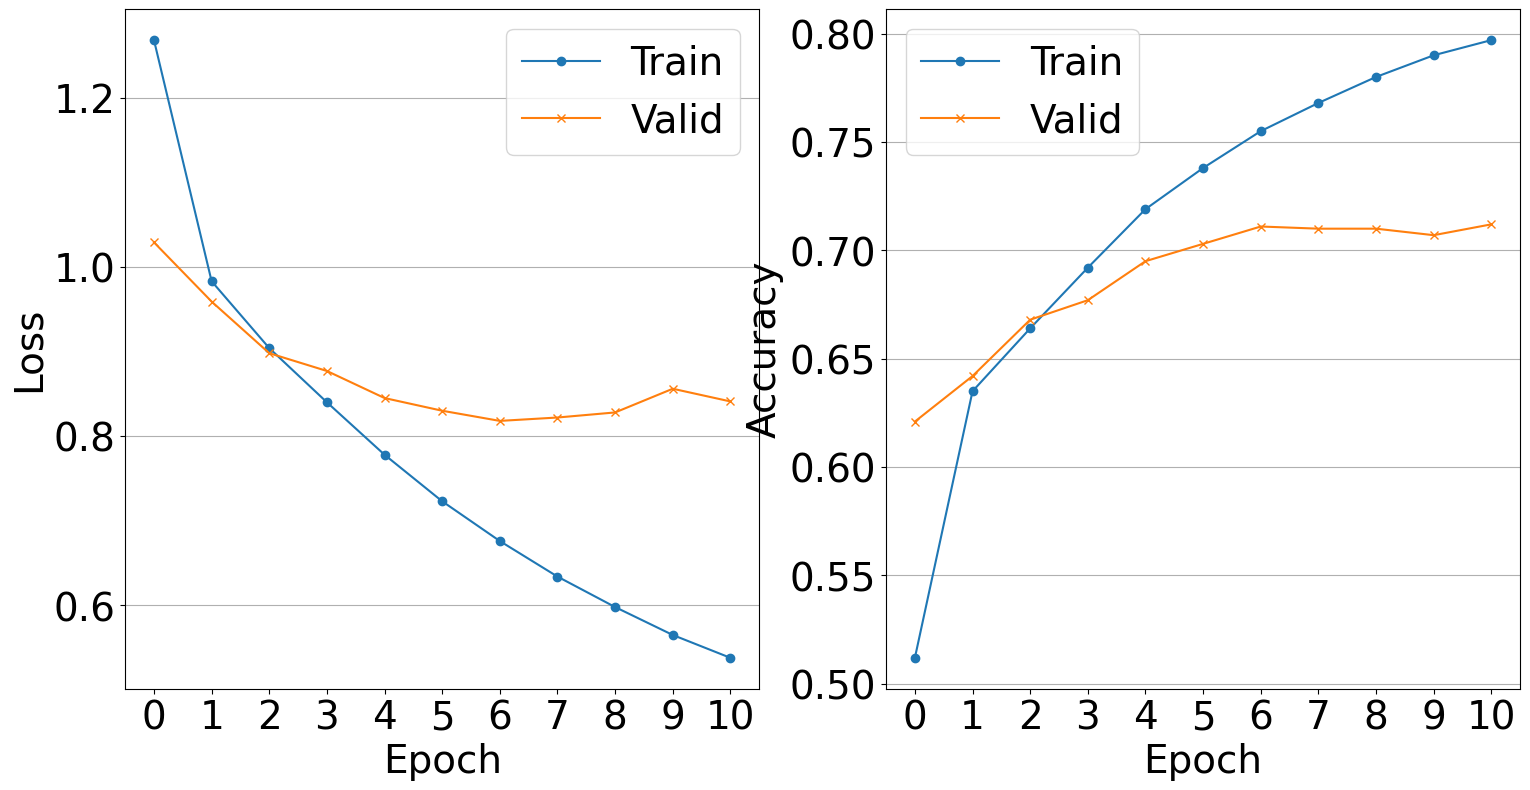

In [18]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), dpi=100)
plot1 = axes[0].plot(range(len(train_losses)), train_losses, marker='o', label='Train')
plot1 = axes[0].plot(range(len(train_losses)), valid_losses, marker='x', label='Valid')

plot2 = axes[1].plot(range(len(train_accuracy)), train_accuracy, marker='o', label='Train')
plot2 = axes[1].plot(range(len(train_accuracy)), valid_accuracy, marker='x', label='Valid')

ylabels = ['Loss', 'Accuracy']
for i in range(2):
    axes[i].legend()
    axes[i].set_xticks([y for y in range(len(train_losses))])
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel('Epoch')
    axes[i].yaxis.grid(True)
    
fig.savefig('instructions_generator_0_5_teacher_forcing.png')

## IL with Instructions

### Set up

In [23]:
il_config.random_seed = 321
il_config.validation_split = 0.2
il_config.

In [36]:
train = imitation_learning_generative_language_trainer.train
validate = imitation_learning_generative_language_trainer.validate
validate_game = imitation_learning_generative_language_trainer.validate_game

instr_config = InstrConfig()
lstm_model = InstructionsGeneratorModel(
    instr_config.device
    , vocab
    , instr_config.embedding_dim
    , vocab_weights
).to(instr_config.device)
il_model = ImitationLearningGenerativeLanguageModel(il_config).to(il_config.device)

# CE Loss
lstm_criterion = torch.nn.CrossEntropyLoss()
il_criterion = torch.nn.CrossEntropyLoss()

# Adam
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=il_config.learning_rate)
il_optimizer = torch.optim.Adam(il_model.parameters(), lr=il_config.learning_rate)

# Log
writer = SummaryWriter() if il_config.summary_writer else None

### Go

In [37]:
best_valid_loss, best_valid_acc, best_valid_reward= float('inf'), float('inf'), float('inf')
valid_epoch, best_epoch = 0, None

train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

for epoch in range(il_config.epochs):
    # train
    loss, accuracy, lstm_loss, bleu, token_acc = train(epoch, train_data_loader, lstm_model, lstm_optimizer, lstm_criterion, il_model, il_optimizer, il_criterion, vocab, il_config, summary_writer=writer)
    print('Overall Epoch: %d, train loss: %.3f, train accuracy: %.3f, train lstm loss: %.3f, train bleu: %.3f, train token acc: %.3f' % (epoch, loss, accuracy, lstm_loss, bleu, token_acc))
    train_losses.append(loss)
    train_accuracy.append(accuracy)
    # valid
    loss, accuracy, lstm_loss, bleu, token_acc = validate(epoch, validation_data_loader, lstm_model, lstm_criterion, il_model, il_criterion, vocab, il_config, summary_writer=writer)
    valid_losses.append(loss)
    valid_accuracy.append(accuracy)
    # valid game
    sum_rewards = validate_game(epoch, lstm_model, il_model, il_config, cache=config.glove_cache)
    print('Overall Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid lstm loss: %.3f, valid bleu: %.3f, valid token acc: %.3f, valid sum rewards: %.3f' % (epoch, loss, accuracy, lstm_loss, bleu, token_acc, sum_rewards))
    # early stopping
    if loss <= best_valid_loss:
        best_valid_loss, best_valid_acc, best_valid_reward = loss, accuracy, sum_rewards
        valid_epoch, best_epoch = 0, epoch
        torch.save(il_model.state_dict(), il_config.SAVE_PATH)
        torch.save(lstm_model.state_dict(), il_config.LSTM_SAVE_PATH)
        print('Best Epoch: %d, valid loss: %.3f, valid accuracy: %.3f, valid sum rewards: %.3f' \
              % (best_epoch, best_valid_loss, best_valid_acc, best_valid_reward))
        print('Trained model saved at ', il_config.SAVE_PATH)
    else:
        valid_epoch += 1
        if valid_epoch >= il_config.valid_patience:
            break

Epoch: 0, train action loss: 1.030, train lang loss: 2.834, train action acc: 0.597, train bleu: 0.560, train token acc: 0.690: 100%|██████████| 2535/2535 [04:26<00:00,  9.51it/s]


Overall Epoch: 0, train loss: 1.231, train accuracy: 0.527, train lstm loss: 3.563, train bleu: 0.481, train token acc: 0.608


Epoch: 0, valid action loss: 1.154, valid lang loss: 4.347, valid action acc: 0.617, valid bleu: 0.306, valid token acc: 0.314: 100%|██████████| 634/634 [01:02<00:00, 10.09it/s]
100%|██████████| 15/15 [00:20<00:00,  1.35s/it]


Overall Epoch: 0, valid loss: 1.077, valid accuracy: 0.601, valid lstm loss: 4.460, valid bleu: 0.280, valid token acc: 0.293, valid sum rewards: 2.000
Best Epoch: 0, valid loss: 1.077, valid accuracy: 0.601, valid sum rewards: 2.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 1, train action loss: 0.816, train lang loss: 2.518, train action acc: 0.661, train bleu: 0.569, train token acc: 0.727: 100%|██████████| 2535/2535 [04:31<00:00,  9.35it/s]


Overall Epoch: 1, train loss: 0.934, train accuracy: 0.657, train lstm loss: 3.183, train bleu: 0.506, train token acc: 0.637


Epoch: 1, valid action loss: 0.820, valid lang loss: 4.513, valid action acc: 0.702, valid bleu: 0.227, valid token acc: 0.264: 100%|██████████| 634/634 [01:03<00:00, 10.06it/s]
100%|██████████| 15/15 [00:20<00:00,  1.40s/it]


Overall Epoch: 1, valid loss: 1.009, valid accuracy: 0.624, valid lstm loss: 4.532, valid bleu: 0.281, valid token acc: 0.297, valid sum rewards: 1.000
Best Epoch: 1, valid loss: 1.009, valid accuracy: 0.624, valid sum rewards: 1.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 2, train action loss: 0.802, train lang loss: 2.615, train action acc: 0.710, train bleu: 0.622, train token acc: 0.749: 100%|██████████| 2535/2535 [04:30<00:00,  9.38it/s]


Overall Epoch: 2, train loss: 0.849, train accuracy: 0.686, train lstm loss: 3.106, train bleu: 0.513, train token acc: 0.644


Epoch: 2, valid action loss: 0.977, valid lang loss: 4.536, valid action acc: 0.638, valid bleu: 0.238, valid token acc: 0.259: 100%|██████████| 634/634 [01:02<00:00, 10.19it/s]
100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


Overall Epoch: 2, valid loss: 0.969, valid accuracy: 0.638, valid lstm loss: 4.547, valid bleu: 0.284, valid token acc: 0.298, valid sum rewards: 2.000
Best Epoch: 2, valid loss: 0.969, valid accuracy: 0.638, valid sum rewards: 2.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 3, train action loss: 0.613, train lang loss: 2.723, train action acc: 0.742, train bleu: 0.570, train token acc: 0.716: 100%|██████████| 2535/2535 [04:28<00:00,  9.45it/s]


Overall Epoch: 3, train loss: 0.777, train accuracy: 0.711, train lstm loss: 3.039, train bleu: 0.520, train token acc: 0.652


Epoch: 3, valid action loss: 0.726, valid lang loss: 4.706, valid action acc: 0.766, valid bleu: 0.209, valid token acc: 0.234: 100%|██████████| 634/634 [01:04<00:00,  9.77it/s]
100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Overall Epoch: 3, valid loss: 0.938, valid accuracy: 0.662, valid lstm loss: 4.541, valid bleu: 0.283, valid token acc: 0.291, valid sum rewards: 4.000
Best Epoch: 3, valid loss: 0.938, valid accuracy: 0.662, valid sum rewards: 4.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 4, train action loss: 0.784, train lang loss: 3.579, train action acc: 0.661, train bleu: 0.541, train token acc: 0.620: 100%|██████████| 2535/2535 [04:30<00:00,  9.36it/s]


Overall Epoch: 4, train loss: 0.708, train accuracy: 0.740, train lstm loss: 3.014, train bleu: 0.523, train token acc: 0.654


Epoch: 4, valid action loss: 1.032, valid lang loss: 4.649, valid action acc: 0.660, valid bleu: 0.274, valid token acc: 0.284: 100%|██████████| 634/634 [01:07<00:00,  9.40it/s]
100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


Overall Epoch: 4, valid loss: 0.912, valid accuracy: 0.678, valid lstm loss: 4.511, valid bleu: 0.284, valid token acc: 0.282, valid sum rewards: 3.000
Best Epoch: 4, valid loss: 0.912, valid accuracy: 0.678, valid sum rewards: 3.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 5, train action loss: 0.629, train lang loss: 3.410, train action acc: 0.726, train bleu: 0.431, train token acc: 0.562: 100%|██████████| 2535/2535 [04:37<00:00,  9.15it/s]


Overall Epoch: 5, train loss: 0.646, train accuracy: 0.765, train lstm loss: 2.971, train bleu: 0.527, train token acc: 0.659


Epoch: 5, valid action loss: 0.862, valid lang loss: 4.714, valid action acc: 0.638, valid bleu: 0.308, valid token acc: 0.294: 100%|██████████| 634/634 [01:02<00:00, 10.17it/s]
100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


Overall Epoch: 5, valid loss: 0.914, valid accuracy: 0.690, valid lstm loss: 4.587, valid bleu: 0.284, valid token acc: 0.294, valid sum rewards: 5.000


Epoch: 6, train action loss: 0.545, train lang loss: 2.403, train action acc: 0.726, train bleu: 0.576, train token acc: 0.738: 100%|██████████| 2535/2535 [04:32<00:00,  9.31it/s]


Overall Epoch: 6, train loss: 0.595, train accuracy: 0.784, train lstm loss: 2.944, train bleu: 0.532, train token acc: 0.663


Epoch: 6, valid action loss: 1.036, valid lang loss: 4.658, valid action acc: 0.745, valid bleu: 0.205, valid token acc: 0.219: 100%|██████████| 634/634 [01:04<00:00,  9.89it/s]
100%|██████████| 15/15 [00:21<00:00,  1.42s/it]


Overall Epoch: 6, valid loss: 0.910, valid accuracy: 0.693, valid lstm loss: 4.592, valid bleu: 0.282, valid token acc: 0.288, valid sum rewards: 2.000
Best Epoch: 6, valid loss: 0.910, valid accuracy: 0.693, valid sum rewards: 2.000
Trained model saved at  /google/src/cloud/billzhou/ask_your_human/google3/experimental/users/billzhou/Ask-Your-Humans/res/cpts/IL.pt


Epoch: 7, train action loss: 0.564, train lang loss: 3.455, train action acc: 0.823, train bleu: 0.461, train token acc: 0.569: 100%|██████████| 2535/2535 [04:33<00:00,  9.26it/s]


Overall Epoch: 7, train loss: 0.550, train accuracy: 0.799, train lstm loss: 2.923, train bleu: 0.535, train token acc: 0.666


Epoch: 7, valid action loss: 0.822, valid lang loss: 4.391, valid action acc: 0.702, valid bleu: 0.235, valid token acc: 0.261: 100%|██████████| 634/634 [01:05<00:00,  9.62it/s]
100%|██████████| 15/15 [00:21<00:00,  1.43s/it]


Overall Epoch: 7, valid loss: 0.936, valid accuracy: 0.693, valid lstm loss: 4.472, valid bleu: 0.283, valid token acc: 0.286, valid sum rewards: 3.000


Epoch: 8, train action loss: 0.447, train lang loss: 2.429, train action acc: 0.823, train bleu: 0.573, train token acc: 0.737: 100%|██████████| 2535/2535 [04:33<00:00,  9.27it/s]


Overall Epoch: 8, train loss: 0.514, train accuracy: 0.812, train lstm loss: 2.927, train bleu: 0.534, train token acc: 0.664


Epoch: 8, valid action loss: 0.864, valid lang loss: 4.410, valid action acc: 0.660, valid bleu: 0.301, valid token acc: 0.297: 100%|██████████| 634/634 [01:06<00:00,  9.49it/s]
100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


Overall Epoch: 8, valid loss: 0.922, valid accuracy: 0.690, valid lstm loss: 4.574, valid bleu: 0.283, valid token acc: 0.287, valid sum rewards: 0.000


Epoch: 9, train action loss: 0.533, train lang loss: 2.497, train action acc: 0.790, train bleu: 0.540, train token acc: 0.698: 100%|██████████| 2535/2535 [04:36<00:00,  9.16it/s]


Overall Epoch: 9, train loss: 0.483, train accuracy: 0.820, train lstm loss: 2.908, train bleu: 0.536, train token acc: 0.667


Epoch: 9, valid action loss: 0.960, valid lang loss: 4.536, valid action acc: 0.660, valid bleu: 0.311, valid token acc: 0.327: 100%|██████████| 634/634 [01:00<00:00, 10.41it/s]
100%|██████████| 15/15 [00:20<00:00,  1.38s/it]


Overall Epoch: 9, valid loss: 0.915, valid accuracy: 0.703, valid lstm loss: 4.605, valid bleu: 0.281, valid token acc: 0.300, valid sum rewards: 2.000


Epoch: 10, train action loss: 0.376, train lang loss: 3.626, train action acc: 0.919, train bleu: 0.552, train token acc: 0.638: 100%|██████████| 2535/2535 [04:37<00:00,  9.15it/s]


Overall Epoch: 10, train loss: 0.457, train accuracy: 0.830, train lstm loss: 2.900, train bleu: 0.537, train token acc: 0.667


Epoch: 10, valid action loss: 1.091, valid lang loss: 4.380, valid action acc: 0.660, valid bleu: 0.310, valid token acc: 0.312: 100%|██████████| 634/634 [01:07<00:00,  9.43it/s]
100%|██████████| 15/15 [00:19<00:00,  1.28s/it]

Overall Epoch: 10, valid loss: 0.950, valid accuracy: 0.699, valid lstm loss: 4.605, valid bleu: 0.281, valid token acc: 0.286, valid sum rewards: 4.000


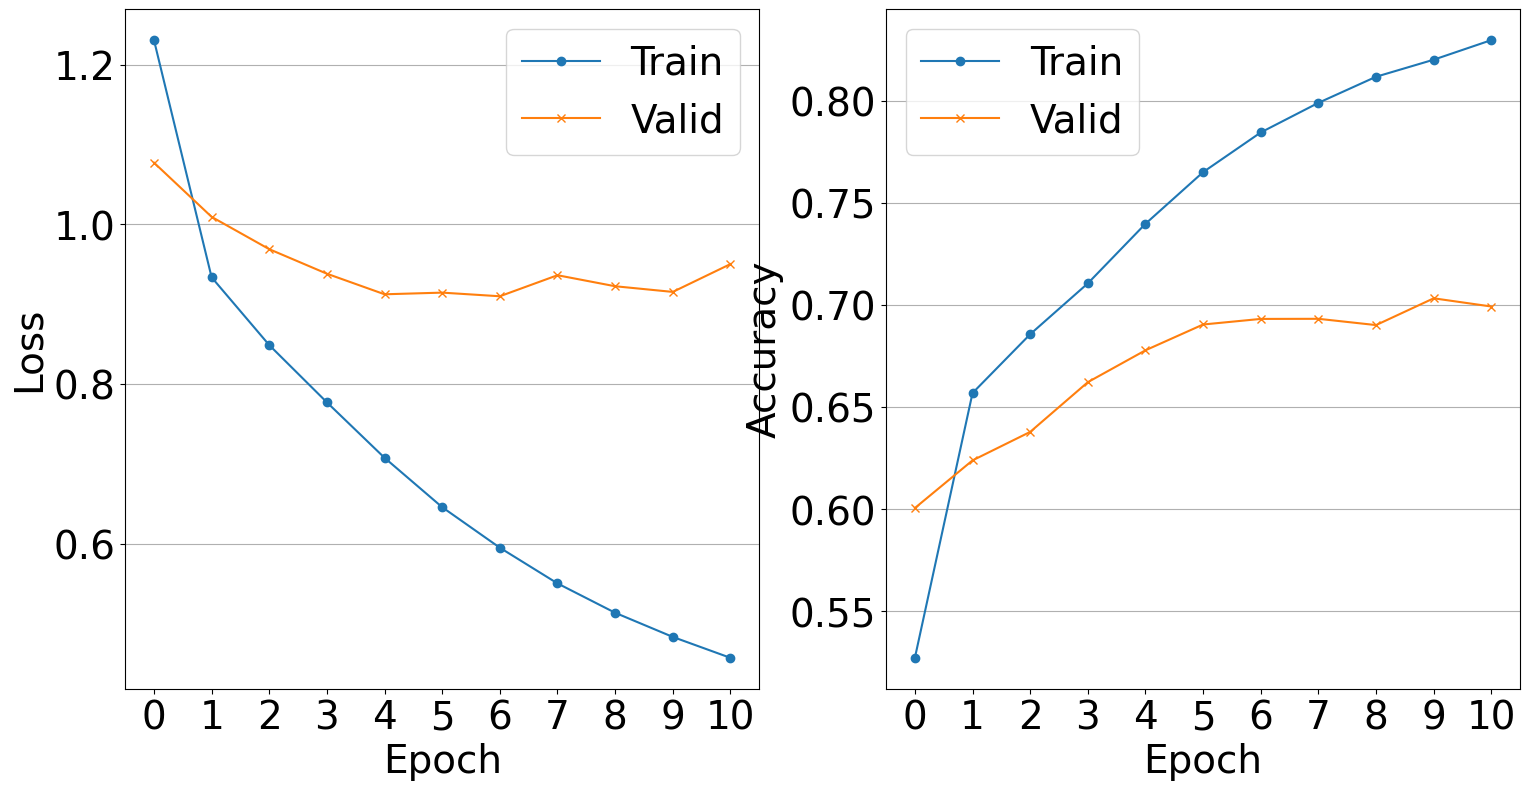

In [40]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 28})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9), dpi=100)
plot1 = axes[0].plot(range(len(train_losses)), train_losses, marker='o', label='Train')
plot1 = axes[0].plot(range(len(train_losses)), valid_losses, marker='x', label='Valid')

plot2 = axes[1].plot(range(len(train_accuracy)), train_accuracy, marker='o', label='Train')
plot2 = axes[1].plot(range(len(train_accuracy)), valid_accuracy, marker='x', label='Valid')

ylabels = ['Loss', 'Accuracy']
for i in range(2):
    axes[i].legend()
    axes[i].set_xticks([y for y in range(len(train_losses))])
    axes[i].set_ylabel(ylabels[i])
    axes[i].set_xlabel('Epoch')
    axes[i].yaxis.grid(True)
    
fig.savefig('il_lstm.png')

In [21]:
il_config.game_file_name = 'length3task.yaml'
il_config.game_file_name

'length3task.yaml'

In [19]:
# il_model.load_state_dict(torch.load(il_config.SAVE_PATH))
# lstm_model.load_state_dict(torch.load(il_config.LSTM_SAVE_PATH))

<All keys matched successfully>

In [22]:
sum_rewards = validate_game(1, lstm_model, il_model, il_config, cache=config.glove_cache)
print(sum_rewards)
sum_rewards = validate_game(1, lstm_model, il_model, il_config, cache=config.glove_cache)
print(sum_rewards)
sum_rewards = validate_game(1, lstm_model, il_model, il_config, cache=config.glove_cache)
print(sum_rewards)

100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


0


100%|██████████| 15/15 [00:26<00:00,  1.75s/it]


0


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]

0


---

# Reinforcement Learning (RL) - Fine-tuning

In [34]:
# TODO